# **Neural steering controller for an autonomous race car**

This model implements the Model-Structured Neural Network steering controller MS-NN-steer of the paper titled:

*Model-Structured Neural Networks to Control the Steering Dynamics of Autonomous Race Cars*

## Initialization

### Import packages

In [2]:
import sys
import os
import torch
import pandas as pd
import scipy as sp
import numpy as np
from nnodely.support.utils import *

print('Current working directory: ',os.getcwd())
sys.path.append(os.path.join(os.getcwd(),'..'))
from nnodely import *
from nnodely.support import earlystopping
# import a library for plots
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
#mpl.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
plt.close('all')
SMALL_SIZE = 14
MEDIUM_SIZE = 22
BIGGER_SIZE = 26
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('grid', linestyle="--", color='grey')

# enable zooming on the plots
%matplotlib inline
import mpld3
mpld3.enable_notebook()


/var/folders/gb/sb7wt0_92m9cdqdrp19t4rr40000gn/T/ipykernel_1845/3022858875.py:5: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 2.3.2)
  import scipy as sp


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>-- nnodely_v1.5.1 --<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
Current working directory:  /Users/giovanni/Desktop/Projects/nnodely-applications/vehicle/control_steer_dynamics_A2RL


### Configurations and known constant parameters

In [3]:
# Path to the data folder
data_folder = os.path.join(os.getcwd(),'A2RL_data')


## NN model

### Custom parametric functions

In [4]:
# -------------------------------------------------
# Normalization function
# -------------------------------------------------
def normalize_fun(x,x_max):
  return x/x_max

# -------------------------------------------------
# Saturation function
# -------------------------------------------------
def sat_fun(x,x_min,x_max):
  return torch.min(torch.max(x,x_min),x_max)

# -------------------------------------------------
# Absolute value function
# -------------------------------------------------
def abs_fun(x):
  return torch.abs(x)

# -------------------------------------------------
# Handling diagram
# -------------------------------------------------
def handling_diagr_local(curv,ay,ax,vx_norm,  # inputs
                         ay_0,ax_0,L,       # constants
                         k1_vx,k2_vx,            # learnable arrays of parameters
                         S_ay,S_ax          # learnable arrays of parameters
                         ):
  sign_ay = torch.sign(ay)  # sign of the lateral acceleration

  # compute k1, as a function of vx 
  k1_vx_fun = k1_vx[0,0,0]
  for ii in range(1,k1_vx.size(2)):
    k1_vx_fun = k1_vx_fun + k1_vx[0,0,ii]*torch.pow(vx_norm,ii)

  # compute k2, as a function of vx
  k2_vx_fun = k2_vx[0,0,0]
  for ii in range(1,k2_vx.size(2)):
    k2_vx_fun = k2_vx_fun + k2_vx[0,0,ii]*torch.pow(vx_norm,ii)

  # learnable weights of the local model for ay around ay_0
  S_ay_1 = S_ay[0,0,0]
  S_ay_2 = S_ay[0,0,1]
  S_ay_3 = S_ay[0,0,2]
  S_ay_4 = S_ay[0,0,3]

  # learnable weights of the local model for ax around ax_0
  S_ax_1 = S_ax[0,0,0]
  S_ax_2 = S_ax[0,0,1]
  S_ax_3 = S_ax[0,0,2]
  S_ax_4 = S_ax[0,0,3]
  S_ax_5 = S_ax[0,0,4]
    
  # output of the local model of the handling diagram
  output = curv*L + k1_vx_fun*sign_ay + k2_vx_fun*(ay - ay_0*sign_ay) +\
           S_ay_1*S_ax_1*(ay - (ay_0+S_ay_2)*sign_ay)*(S_ax_2 + ax - ax_0)*(1 + \
           S_ay_3*(ay - ay_0*sign_ay) + S_ax_3*(ax - ax_0) + S_ax_4*(ax - ax_0)**2 + \
           S_ay_4*S_ax_5*(ay - ay_0*sign_ay)*(ax - ax_0))
  return output

### Hyperparameters and configurations for the internal model

In [5]:
# -----------------------------------------------
# Neural model inputs and outputs
# -----------------------------------------------
curv         = Input('curv')          # [1/m] path curvature
vx           = Input('vx')            # [m/s] longitudinal velocity  
ay           = Input('ay')            # [m/s^2] lateral acceleration
ax           = Input('ax')            # [m/s^2] longitudinal acceleration
steer_target = Input('steer_target')  # [rad] steering wheel angle --> this is used only as a training target
L = Constant('L',values=3.115)  # [m] wheelbase
# -----------------------------------------------
# Saturation values for the inputs
# -----------------------------------------------
# Load the training and validation data
flag=0
if flag==0:
  name_folder = '/Large/'
  number_training=2792 
  number_validation= 2992
elif flag==1:
  name_folder = '/medium/' 
  number_training=1792 
  number_validation= 2992
elif flag==2:
  name_folder = '/Short/' 
  number_training=792 
  number_validation= 2992


data_folder_train = os.path.join(data_folder,'training'+ name_folder)
data_folder_valid = os.path.join(data_folder,'validation'+  name_folder)

# Extract the max values of ay and vx from the training set
max_ay   = max(abs(pd.read_csv(os.path.join(data_folder_train,'training_single_lap.csv'))['ay'].values)).item()
max_ay_val   = max(abs(pd.read_csv(os.path.join(data_folder_valid,'Validation_single_lap.csv'))['ay'].values)).item()

max_curv = max(abs(pd.read_csv(os.path.join(data_folder_train,'training_single_lap.csv'))['curv'].values)).item()

min_vx = min(pd.read_csv(os.path.join(data_folder_train,'training_single_lap.csv'))['vx'].values).item()
max_vx = max(pd.read_csv(os.path.join(data_folder_train,'training_single_lap.csv'))['vx'].values).item()
min_vx_val = min(pd.read_csv(os.path.join(data_folder_valid,'Validation_single_lap.csv'))['vx'].values).item()
max_vx_val = max(pd.read_csv(os.path.join(data_folder_valid,'Validation_single_lap.csv'))['vx'].values).item()

min_ax = np.percentile(pd.read_csv(os.path.join(data_folder_train,'training_single_lap.csv'))['ax'].values,0.2,axis=0).item()
max_ax = np.percentile(pd.read_csv(os.path.join(data_folder_train,'training_single_lap.csv'))['ax'].values,99.92,axis=0).item()
min_ax_val = np.percentile(pd.read_csv(os.path.join(data_folder_valid,'Validation_single_lap.csv'))['ax'].values,0.2,axis=0).item()
max_ax_val = np.percentile(pd.read_csv(os.path.join(data_folder_valid,'Validation_single_lap.csv'))['ax'].values,99.92,axis=0).item()


print('max_ay   = ', max_ay)
print('max_ay_2   = ', max_ay_val)
print('max_curv = ', max_curv)
print('min_vx   = ', min_vx)
print('max_vx   = ', max_vx)
print('min_vx_2   = ', min_vx_val)
print('max_vx_2   = ', max_vx_val)
print('min_ax   = ', min_ax)
print('max_ax   = ', max_ax)
print('min_ax_2   = ', min_ax_val)
print('max_ax_2   = ', max_ax_val)

# -----------------------------------------------
# Window sizes, channels, and others
# -----------------------------------------------
# Window size for the inputs
num_samples_future_feedfw = 10  # number of future samples in the feedforward part of the model

# Channels for the lateral acceleration ay
num_channels_ay = 5
chan_centers_ay = list(np.linspace(0.0, max_ay_val, num_channels_ay))  # centers of the channels

# Channels for the forward speed vx
num_channels_vx = 3
chan_centers_vx = list(np.linspace(min_vx_val, max_vx_val, num=num_channels_vx))  # centers of the channels

# Channels for the longitudinal acceleration ax
num_channels_ax         = 3
perc_neg_ax             = 0.5   # percentage of channels dedicated to negative ax
extra_margin_ax_centers = 0.5   # extra margin for the centers of the channels
# Define the center points of the channels (make sure to capture ax = 0)
chan_centers_ax = np.linspace(min_ax_val - extra_margin_ax_centers, 0, num=int(num_channels_ax*perc_neg_ax), endpoint=False)
chan_centers_ax = list(np.append(chan_centers_ax, np.linspace(0, max_ax_val + extra_margin_ax_centers, 
                                                              num=num_channels_ax - int(num_channels_ax*perc_neg_ax))))

print('chan_centers_ay = ', chan_centers_ay)
print('chan_centers_vx = ', chan_centers_vx)
print('chan_centers_ax = ', chan_centers_ax)


# degree of the polynomial to fit k1, as a function of vx
poly_degree_k1_vx = 3
# degree of the polynomial to fit k2, as a function of vx
poly_degree_k2_vx = 1

# -----------------------------------------------
# Initial guesses and constants
# -----------------------------------------------
# Load the initial guesses for the handling diagram model, computed in Matlab with a 2nd order optimizer
initial_guesses_handling_diagr = sp.io.loadmat(os.path.join(data_folder,
                                                            str(num_channels_ay) + '_lin_models_ay_poly_deg_' + 
                                                            str(poly_degree_k1_vx) + '_' + str(poly_degree_k2_vx) + '_vx.mat'))
k1_vx_array_guess = initial_guesses_handling_diagr['optim_params_save']['k1_vx'][0][0][0]
k2_vx_array_guess = initial_guesses_handling_diagr['optim_params_save']['k2_vx'][0][0][0]

k1_vx_array_guess = k1_vx_array_guess.reshape(num_channels_ay, poly_degree_k1_vx+1)
k2_vx_array_guess = k2_vx_array_guess.reshape(num_channels_ay, poly_degree_k2_vx+1)


# -----------------------------------------------
# Pre-process the inputs
# -----------------------------------------------
vx_norm = ParamFun(normalize_fun)(vx.sw([0,num_samples_future_feedfw]),max_vx)  # normalized longitudinal velocity
ay_abs  = ParamFun(abs_fun)(ay.sw([0,num_samples_future_feedfw]))  # absolute value of the lateral acceleration

# Saturated inputs
ay_sat     = ParamFun(sat_fun)(ay.sw([0,num_samples_future_feedfw]),-max_ay,max_ay)
curv_sat   = ParamFun(sat_fun)(curv.sw([0,num_samples_future_feedfw]),-max_curv,max_curv)
ax_sat     = ParamFun(sat_fun)(ax.sw([0,num_samples_future_feedfw]),min_ax,max_ax)
vx_sat     = ParamFun(sat_fun)(vx.sw([0,num_samples_future_feedfw]),min_vx,max_vx)
ay_abs_sat = ParamFun(abs_fun)(ay_sat)

# -----------------------------------------------
# Local models of the extended handling diagram, 
# to model the quasi-steady-state combined lateral vehicle dynamics
# -----------------------------------------------
# Define the activation functions for the local models (aka channels)
activ_fcns_ay = Fuzzify(centers=chan_centers_ay, functions='Triangular')(ay_abs_sat)
activ_fcns_ax = Fuzzify(centers=chan_centers_ax, functions='Triangular')(ax_sat)

# Define the centers of the channels for ay, ax, and az:
chan_centers_ay_list, chan_centers_ax_list = [], []
for idx_ay in range(num_channels_ay):
  chan_centers_ay_list.append(Constant('ay_center_' + str(idx_ay), values=chan_centers_ay[idx_ay]))
for idx_ax in range(num_channels_ax):
  chan_centers_ax_list.append(Constant('ax_center_' + str(idx_ax), values=chan_centers_ax[idx_ax]))

# Define the learnable arrays of parameters:

# Parameters to learn the vx-dependent shape of the handling diagram with local models
k1_vx_guess_list, k2_vx_guess_list = [], []
for idx_ay in range(num_channels_ay):
  k1_vx_guess_list.append(Parameter('k1_vx_' + str(idx_ay),values=[[list(k1_vx_array_guess[idx_ay,:])]]))  # initial guess
  k2_vx_guess_list.append(Parameter('k2_vx_' + str(idx_ay),values=[[list(k2_vx_array_guess[idx_ay,:])]]))  # initial guess
                          
# Parameters to learn the local models for the handling diagram, as a function of ay, ax and az
S_ay_guess_list, S_ax_guess_list = [], []
num_S_ay_params = 4
num_S_ax_params = 5
# Initialize with random values with a certain standard deviation
np.random.seed(1) 
first_value = np.random.normal(0,1e-4)

for idx_ay in range(num_channels_ay):
  sigma_S_ay = 1e-4
  S_ay_guess = np.random.normal(0,sigma_S_ay,num_S_ay_params)
  S_ay_guess_list.append(Parameter('S_ay_' + str(idx_ay),values=[[list(S_ay_guess)]]))  # initial guess
for idx_ax in range(num_channels_ax):
  sigma_S_ax = 1e-3
  S_ax_guess = np.random.normal(0,sigma_S_ax,num_S_ax_params)
  S_ax_guess_list.append(Parameter('S_ax_' + str(idx_ax),values=[[list(S_ax_guess)]]))  # initial guess

# Handling diagram function for the local models
handling_diagr = ParamFun(handling_diagr_local)

# Handling diagram function generator
def handling_diagr_gen(idx_list):
  # define an auxiliary function to allocate new parameters for each channel:
  # the inputs of this function will be passed by the LocalModel object
  def handling_diagr_map(curv,ay,ax,vx_norm):
    idx_ay, idx_ax = idx_list[0], idx_list[1]   # indices of the channels for ay, ax and az
    ay_0 = chan_centers_ay_list[idx_ay]  # center of the channel for ay
    ax_0 = chan_centers_ax_list[idx_ax]  # center of the channel for ax
    k1_vx = k1_vx_guess_list[idx_ay]     # learnable array of parameters for k1, as a function of vx
    k2_vx = k2_vx_guess_list[idx_ay]     # learnable array of parameters for k2, as a function of vx
    S_ay = S_ay_guess_list[idx_ay]       # learnable array of parameters for the local model of ay
    S_ax = S_ax_guess_list[idx_ax]       # learnable array of parameters for the local model of ax
    return handling_diagr(curv,ay,ax,vx_norm,        # inputs
                          ay_0,ax_0,L,             # constants
                          k1_vx,k2_vx,S_ay,S_ax   # learnable arrays of parameters
                          )
  return handling_diagr_map

out_local_models_handling_diagr = LocalModel(input_function=handling_diagr_gen, pass_indexes=True)((curv_sat,ay_sat,ax_sat,vx_norm),
                                                                                                   (activ_fcns_ay,activ_fcns_ax))

# -----------------------------------------------
# Local models for the transient lateral vehicle dynamics
# -----------------------------------------------
# Define the activation functions for the local models
activ_fcns_vx = Fuzzify(centers=chan_centers_vx, functions='Triangular')(vx.sw([0,num_samples_future_feedfw]))

# Define and call the local model for the transient dynamics
local_model_trans_dyna = LocalModel(output_function=lambda: Fir(W_init = init_exp, 
                                                                W_init_params={'size_index':0, 'max_value':first_value, 
                                                                                       'lambda':5, 'monotonicity':'decreasing'}))
out_local_model_trans_dyna = local_model_trans_dyna(out_local_models_handling_diagr, (activ_fcns_vx,activ_fcns_ax))

# Model output
out_NN = Output('steering_angle', out_local_model_trans_dyna) 

max_ay   =  17.4789927602204
max_ay_2   =  18.1879657244957
max_curv =  0.0678973712302635
min_vx   =  12.8619979988317
max_vx   =  63.5807290222844
min_vx_2   =  12.3699633005119
max_vx_2   =  63.5807290222844
min_ax   =  -16.801766327676518
max_ax   =  8.896746140973896
min_ax_2   =  -20.1134272365284
max_ax_2   =  8.885254469609816
chan_centers_ay =  [np.float64(0.0), np.float64(4.546991431123925), np.float64(9.09398286224785), np.float64(13.640974293371777), np.float64(18.1879657244957)]
chan_centers_vx =  [np.float64(12.3699633005119), np.float64(37.97534616139815), np.float64(63.5807290222844)]
chan_centers_ax =  [np.float64(-20.6134272365284), np.float64(0.0), np.float64(9.385254469609816)]


### Internal architecture

### nnodely definitions

In [6]:
# Create a nnodely model
path_folder_save = os.path.join(os.getcwd(),'A2RL_data/trained_models','control_steer_dynamics_A2RL')  # folder to save the model
steer_controller_extended = nnodely(visualizer='Standard',seed=12,workspace=path_folder_save,save_history=False)  #visualizer=MPLVisulizer()

# Add the neural model to the nnodely structure and neuralization of the model
steer_controller_extended.addModel('steer_ctrl',[out_NN])
steer_controller_extended.addMinimize('steer_error', 
                                      steer_target.next(),  # next means the first value in the "future"
                                      out_NN, 
                                      loss_function='rmse')

# Create the model
steer_controller_extended.neuralizeModel()

================================ nnodely Model =================================
{'Constants': {'Constant14': {'dim': 1, 'values': [-17.478992462158203]},
               'Constant15': {'dim': 1, 'values': [17.478992462158203]},
               'Constant19': {'dim': 1, 'values': [-0.06789737194776535]},
               'Constant20': {'dim': 1, 'values': [0.06789737194776535]},
               'Constant24': {'dim': 1, 'values': [-16.80176544189453]},
               'Constant25': {'dim': 1, 'values': [8.896745681762695]},
               'Constant9': {'dim': 1, 'values': [63.58073043823242]},
               'L': {'dim': 1, 'values': [3.115000009536743]},
               'ax_center_0': {'dim': 1, 'values': [-20.613428115844727]},
               'ax_center_1': {'dim': 1, 'values': [0.0]},
               'ax_center_2': {'dim': 1, 'values': [9.385254859924316]},
               'ay_center_0': {'dim': 1, 'values': [0.0]},
               'ay_center_1': {'dim': 1, 'values': [4.546991348266602]},
     

In [ ]:
#from nnodely.support.jsonutils import plot_graphviz_structure
#plot_graphviz_structure(steer_controller_extended.json)

## Training and validation datasets

In [7]:
# Pass the training and the validation datasets to the nnodely structure
data_struct = ['ay','ax','vx','curv','steer_target','',''] 
steer_controller_extended.loadData(name='Training', source=data_folder_train, format=data_struct, skiplines=1)
steer_controller_extended.loadData(name='Validation', source=data_folder_valid, format=data_struct, skiplines=1)

============================ nnodely Model Dataset =============================
Dataset Name:                 Training
Number of files:              1
Total number of samples:      2792
Shape of ax:                  (2792, 10, 1)
Shape of vx:                  (2792, 10, 1)
Shape of ay:                  (2792, 10, 1)
Shape of curv:                (2792, 10, 1)
Shape of steer_target:        (2792, 1, 1)
============================ nnodely Model Dataset =============================
Dataset Name:                 Validation
Number of files:              1
Total number of samples:      2992
Shape of ax:                  (2992, 10, 1)
Shape of vx:                  (2992, 10, 1)
Shape of ay:                  (2992, 10, 1)
Shape of curv:                (2992, 10, 1)
Shape of steer_target:        (2992, 1, 1)


## Training

In [ ]:

num_epochs = 8000
batch_size = 1000
learn_rate = 1e-3  # learning rate
early_stop_patience = 1500
training_pars = {'num_of_epochs':num_epochs, 
                 'val_batch_size':batch_size, 
                 'train_batch_size':batch_size, 
                 'lr':learn_rate}

flag_train_now = 1
if flag_train_now:
  train_result = steer_controller_extended.trainModel(train_dataset='Validation', validation_dataset='Training',
                                                      training_params=training_pars, optimizer='Adam', shuffle_data=True,
                                                      early_stopping=earlystopping.early_stop_patience,  
                                                      early_stopping_params={'patience':early_stop_patience,
                                                                              'error':'steer_error'})  
else:
  # Load the trained model
  steer_controller_extended.loadModel() 

======================== nnodely Model Train Parameters ========================
models:                       ['steer_ctrl']
num of epochs:                100
update per epochs:            2
└>(n_samples-batch_size)/batch_size+1
shuffle data:                 True
early stopping:               early_stop_patience
early stopping params:        {'error': 'steer_error', 'patience': 1500}
train dataset:                Validation
	- batch size:                1000
	- num of samples:            2992
validation dataset:           Training
	- batch size:                1000
	- num of samples:            2792
minimizers:                   {'steer_error': {'A': 'SamplePart395',
                                               'B': 'Add393',
                                               'loss': 'rmse'}}
optimizer:                    Adam
optimizer defaults:           {'lr': 0.001}
optimizer params:             [{'params': 'PFir64W'},
                               {'params': 'PFir66W'},
          

In [9]:
# Print the trained NN parameters
steer_controller_extended.neuralizeModel()

if flag_train_now:
  # Save the trained model
  steer_controller_extended.saveModel()


================================ nnodely Model =================================
{'Constants': {'Constant14': {'dim': 1, 'values': [-17.478992462158203]},
               'Constant15': {'dim': 1, 'values': [17.478992462158203]},
               'Constant19': {'dim': 1, 'values': [-0.06789737194776535]},
               'Constant20': {'dim': 1, 'values': [0.06789737194776535]},
               'Constant24': {'dim': 1, 'values': [-16.80176544189453]},
               'Constant25': {'dim': 1, 'values': [8.896745681762695]},
               'Constant9': {'dim': 1, 'values': [63.58073043823242]},
               'L': {'dim': 1, 'values': [3.115000009536743]},
               'ax_center_0': {'dim': 1, 'values': [-20.613428115844727]},
               'ax_center_1': {'dim': 1, 'values': [0.0]},
               'ax_center_2': {'dim': 1, 'values': [9.385254859924316]},
               'ay_center_0': {'dim': 1, 'values': [0.0]},
               'ay_center_1': {'dim': 1, 'values': [4.546991348266602]},
     

#### Test on the Training dataset

RMSE on the test set:  [0.00329718]  rad^2


/Users/giovanni/Desktop/Projects/nnodely-applications/.venv/lib/python3.12/site-packages/mpld3/mplexporter/utils.py:300: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates._SwitchableDateConverter)
/Users/giovanni/Desktop/Projects/nnodely-applications/.venv/lib/python3.12/site-packages/mpld3/mplexporter/utils.py:303: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates.DateConverter)
/Users/giovanni/Desktop/Projects/nnodely-applications/.venv/lib/python3.12/site-packages/mpld3/mplexporter/utils.py:306: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods ins

FileNotFoundError: [Errno 2] No such file or directory: 'Plot/Plot_Training.html'

/Users/giovanni/Desktop/Projects/nnodely-applications/.venv/lib/python3.12/site-packages/mpld3/mplexporter/utils.py:300: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates._SwitchableDateConverter)
/Users/giovanni/Desktop/Projects/nnodely-applications/.venv/lib/python3.12/site-packages/mpld3/mplexporter/utils.py:303: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates.DateConverter)
/Users/giovanni/Desktop/Projects/nnodely-applications/.venv/lib/python3.12/site-packages/mpld3/mplexporter/utils.py:306: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods ins

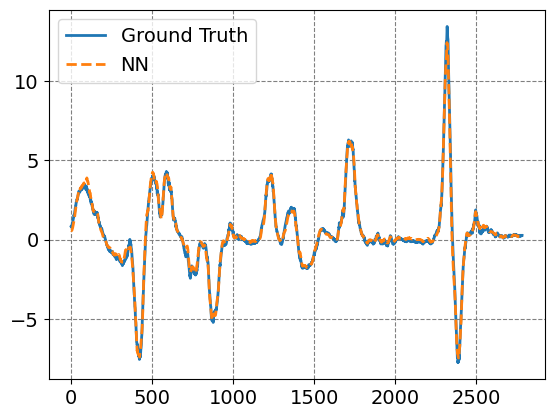

In [10]:
num_samples_use  =number_training-num_samples_future_feedfw
samples_training_set = steer_controller_extended.getSamples('Training', index=0, window=num_samples_use) 
out_nn_trainig_set  = steer_controller_extended(samples_training_set, sampled=True)
out_nn_training_set_extract = np.asarray(out_nn_trainig_set['steering_angle'])

# Extract the samples
samples_training_set_extract = np.zeros((len(samples_training_set['steer_target']),1))
for i in range(0,len(samples_training_set_extract)):
  samples_training_set_extract[i] = samples_training_set['steer_target'][i]

# Compute the RMSE on the test set
mse_calc = 0
for i in range(0,len(samples_training_set_extract)):
  mse_calc = mse_calc + (samples_training_set_extract[i] - out_nn_training_set_extract[i])**2 
mse_calc = np.sqrt(mse_calc/len(samples_training_set_extract))
print('RMSE on the test set: ', mse_calc, ' rad^2')

flag_plot_results = True
if flag_plot_results:
  fig, ax = plt.subplots()
  ax.plot(np.rad2deg(samples_training_set_extract),label='Ground Truth',linewidth=2)
  ax.plot(np.rad2deg(out_nn_training_set_extract),label='NN',linestyle='--',linewidth=2)
  ax.legend()
  ax.grid()
  html_str = mpld3.fig_to_html(fig)
  with open("Plot/Plot_Training.html", "w") as f:
    f.write(html_str)

RMSE on the test set:  [0.00147941]  rad^2


c:\Users\mungi\anaconda3\envs\myenv_2\lib\site-packages\mpld3\mplexporter\utils.py:300: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates._SwitchableDateConverter)
c:\Users\mungi\anaconda3\envs\myenv_2\lib\site-packages\mpld3\mplexporter\utils.py:303: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates.DateConverter)
c:\Users\mungi\anaconda3\envs\myenv_2\lib\site-packages\mpld3\mplexporter\utils.py:306: MatplotlibDeprecationWarning: The converter attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use get_converter and set_converter methods instead.
  isinstance(axis.converter, matplotlib.dates.ConciseDateConverter)
c:\Users\mungi\anaconda3\

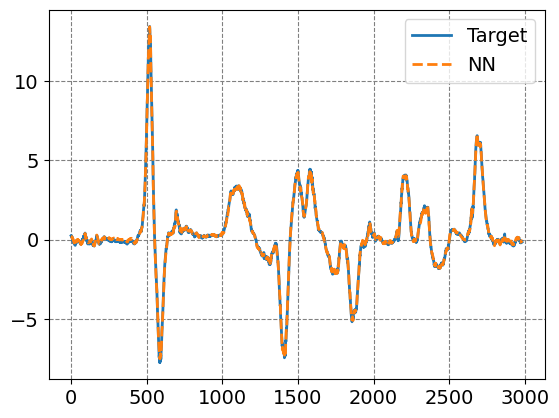

In [61]:

num_samples_use  = number_validation-num_samples_future_feedfw
samples_Validation_set = steer_controller_extended.getSamples('Validation', index=0, window=num_samples_use) 
out_nn_test_set  = steer_controller_extended(samples_Validation_set, sampled=True)
out_nn_Validation_set_extract = np.asarray(out_nn_test_set['steering_angle'])

# Extract the samples
samples_Validation_set_extract = np.zeros((len(samples_Validation_set['steer_target']),1))
for i in range(0,len(samples_Validation_set_extract)):
  samples_Validation_set_extract[i] = samples_Validation_set['steer_target'][i]

# Compute the RMSE on the test set
mse_calc = 0
for i in range(0,len(samples_Validation_set_extract)):
  mse_calc = mse_calc + (samples_Validation_set_extract[i] - out_nn_Validation_set_extract[i])**2 
mse_calc = np.sqrt(mse_calc/len(samples_Validation_set_extract))
print('RMSE on the test set: ', mse_calc, ' rad^2')


flag_plot_results = True
if flag_plot_results:
  fig, ax = plt.subplots()
  ax.plot(np.rad2deg(samples_Validation_set_extract),label='Target',linewidth=2)
  ax.plot(np.rad2deg(out_nn_Validation_set_extract),label='NN',linestyle='--',linewidth=2)
  ax.legend()
  ax.grid()
  html_str = mpld3.fig_to_html(fig)
  with open("Plot/Plot_Validation.html", "w") as f:
    f.write(html_str)